# Semantic Segmentation of Aerial Imagery with Raster Vision 
## Part 8: Modifying Model Configuration - Hyperparameter Tuning

This tutorial series walks through an example of using [Raster Vision](https://rastervision.io/) to train a deep learning model to identify buildings in satellite imagery.</br>

*Primary Libraries and Tools*:

|Name|Description|Link|
|-|-|-|
| `Raster Vision ` | Library and framework for geospatial semantic segmentation, object detection, and chip classification with python| https://rastervision.io/ |
| `Apptainer` | Containerization software that allows for transportable and reproducible software | https://apptainer.org/ |
| `pandas` | Dataframes and other datatypes for data analysis and manipulation | https://pandas.pydata.org/ |
| `geopandas` | Extends datatypes used by pandas to allow spatial operations on geometric types | https://geopandas.org/en/stable/ |
| `rioxarray` | Data structures and routines for working with gridded geospatial data | https://github.com/corteva/rioxarray |
| `plotnine` | A plotting library for Python modeled after R's [ggplot2](https://ggplot2.tidyverse.org/) | https://plotnine.readthedocs.io/en/v0.12.3/ |
| `pathlib` | A Python library for handling files and paths in the filesystem | https://docs.python.org/3/library/pathlib.html |

*Prerequisites*:
  * Basic understanding of navigating the Linux command line, including navigating among directories and editing text files
  * Basic python skills, including an understanding of object-oriented programming, function calls, and basic data types
  * Basic understanding of shell scripts and job scheduling with SLURM for running code on Atlas
  * A SCINet account for running this tutorial on Atlas
  * **Completion of tutorial parts 1-7 of this series**

*Tutorials in this Series*:
  * 1\. **Tutorial Setup on SCINet**
  * 2\. **Overview of Deep Learning for Imagery and the Raster Vision Pipeline**
  * 3\. **Constructing and Exploring the Apptainer Image**
  * 4\. **Exploring the dataset and problem space**
  * 5\. **Overview of Raster Vision Model Configuration and Setup**
  * 6\. **Breakdown of Raster Vision Code Version 1**
  * 7\. **Evaluating Training Performance and Visualizing Predictions**
  * 8\. **Modifying Model Configuration - Hyperparameter Tuning <span style="color: red;">_(You are here)_</span>**
  * 9\. **Modifying Model Configuration - Data Augmentation**

In this tutorial, we will describe how to tune various hyperparameters. In section 1, we will describe how to read optional hyperparameter values into our `run_model2.sh` script using `getopts`, and how to validate the values within our `get_config()` function. In section 2, we will describe common hyperparameters used to improve model performance and decrease model training time. In section 3, we will describe hyperparameters we can change to ensure we cover the entire prediction space. Finally, in section 4, we will show how to use run train multiple models, all with different hyperparameter values, and how to evaluate them comparatively.

We will describe the changes we make from `tiny_spacenet1.py` to `tiny_spacenet2.py`, and from `run_model1.sh` to `run_model2.sh`. We encourage you to open up these scripts to read through them on your own. Not all of the code in `tiny_spacenet2.py` will be included in this tutorial, since much of it is identical to the code in `tiny_spacenet1.py.

#### 1. Reading in optional command line arguments

In tutorial 6, we saw how to read a positional argument into our `run_model1.sh` script. In this tutorial, we want to allow users to modify various hyperparameter values at runtime. We will assign each of these hyperparameters a default value, and allow the user to optionally specify an alternative value when they launch the `run_model2.sh` script. Here is a list of the hyperparameters we will allow users to modify, and their default values. We will describe the role of each of these hyperparameter values in more depth throughout the tutorial.
- Chip size: 220
- Stride length (for prediction chips): 215
- Number of chips generated per image (max_windows): 5
- Number of epochs: 8
- Batch size: 24
- Learning rate: 1e-4

As we described in tutorial 6, there are two steps we need to take to allow the user to specify arguments through the command line: 
1. We need to list the arguments in the `get_config()` function header. We can list a default value here if applicable.
2. We need to update `run_model2.sh` to accept optional command line arguments to pass to the `rastervision run` command.

#### 1.1 Modifying get_config() to read in CL arguments

Here's what the header of the `get_config()` function looks like in `tiny_spacenet2.py`. 

```python
def get_config(runner, 
    output_uri: str, 
    chip_sz: int = 220,
    stride_length: int = 215,
    max_windows: int = 5,
    epochs: int = 8,
    batch_sz: int = 28,
    lr: float = 1e-4) -> SemanticSegmentationConfig:
```

We include type hints and default values for each parameter. Python does not enforce that the values must be of the given type - type hints are listed for the benefit of the developer for documentation purposes. This is good for our use case, since all values we pass to Raster Vision through the command line are interpreted as strings. We must manually cast these values to their desired types. At the very beginning of the `get_config()` function, we attempt to cast each variable to the appropriate type, and throw an error if the variable cannot be cast to that type. Then, we ensure that each variable is within an appropriate range of values. For example, we don't want our chip size to be larger than 650 because each of the images in our dataset is 650x650 pixels. Here is the code we use in `tiny_spacenet2.py` to cast and validate the `chip_sz` variable. We use similar code to cast and validate all of our other hyperparameters, so for brevity we leave out the comparable code to cast and validate all of the other hyperparameters. Readers are encouraged to skim the code at the beginning of `tiny_spacenet2.py` to understand how we cast and validate all the hyperparameters that are set at the command line.

```python
    try:
        chip_sz = int(chip_sz)
    except:
        raise TypeError("chip_sz must be an integer")
    if chip_sz < 1 or chip_sz > 650:
        raise ValueError("Chip size must be between 1 and 650")
```

#### 1.2 Modifying run_model2.sh to accept and pass optional command line arguments

Since there are many hyperparameter values we wish to be able to set from the command line, and the modification of each hyperparameter is optional, it wouldn't be a good idea to use positional arguments as we did in `run_model1.sh`. Instead, we will read in values using the `getopts` utility. 

<b>If you are not familiar with getopts, please read through [this](https://www.geeksforgeeks.org/getopts-command-in-linux-with-examples/) article before proceeding.</b>

Recall that to pass arguments to Raster Vision at runtime, we include them as options to our `rastervision run` call as follows. Each argument name and value is listed as a key-value pair.

`rastervision run -a key1 value1 -a key2 value2 ...`

Since our `get_config()` function lists default values for our hyperparameters, we only need specify hyperparameters if we want to use non-default values. We can do this by initializing an empty string called `ARGLIST`, iterating through the options using the `getopts` utility, and appending string with key-value pairs. Then, we unpack this string into our call to `rastervision run`. Here's what our `run_model2.sh` script looks like now:

```bash
#!/bin/bash -l
#SBATCH -t 150
#SBATCH -A geospatialworkshop
#SBATCH --partition=gpu-a100-mig7
#SBATCH --mem=256gb
#SBATCH --gres=gpu:a100_1g.10gb:1
#SBATCH -n 4
#SBATCH --cpus-per-task=2

function usage {
    echo "usage: sbatch run_model2.sh [OPTIONS]"
    echo "  -c Chip size in pixels. Default = 250."
    echo "  -s Stride length for chips generated via sliding method. Default = 200."
    echo "  -e Number of epochs. Default = 3."
    echo "  -m Max number of chips to generate per image via random method. Default = 5."
    echo "  -b Batch size. Default = 2."
    echo "  -l Learning rate. Default = 1e-4."
    echo "  -o Output directory name. Default = output."
    echo "  -h print usage details"
    exit 1
}

OUT_DIR="output"

ARGLIST=""
OPTSTRING="hc:s:e:m:b:l:o:"
while getopts ${OPTSTRING} opt; do
  case ${opt} in
    c)
      ARGLIST+="-a chip_sz ${OPTARG} "
      ;;
    s)
      ARGLIST+="-a stride_length ${OPTARG} "
      ;;
    e)
      ARGLIST+="-a epochs ${OPTARG} "
      ;;
    m)
      ARGLIST+="-a max_window ${OPTARG} "
      ;;
    b)
      ARGLIST+="-a batch_sz ${OPTARG} "
      ;;
    l)
      ARGLIST+="-a lr ${OPTARG} "
      ;;
    o)
      echo Setting output dir to ${OPTARG}
      OUT_DIR=${OPTARG}
      ;;
    :)
      usage
      ;;
    ?)
      usage
      ;;
  esac
done

if [ ${OUT_DIR} = "output" ]; then
  echo "Warning: using default output directory, 'output'. Existing content in 'output' directory may be overwritten. Specify an alternative output directory by using the -o option."
else
  echo Output directory is ${OUT_DIR}
fi

module load apptainer/1.1.9

apptainer exec --nv --bind /reference/workshops/rastervision/input/:/opt/data/input/ \
--bind `pwd`/local/:/local/ raster-vision_pytorch-0.30.sif \
rastervision run -s 4 -a output_uri `pwd`/$OUT_DIR \
${ARGLIST} local `pwd`/src/tiny_spacenet2.py
```

#### 2. Hyperparameters to tune for performance optimization

There are many hyperparameters that AI practitioners tune to optimize performance. Since we are using a pretrained model backbone, there are some common hyperparameters that are already set for us, such as the number and size of layers in our neural network. Further, Raster Vision does not allow for as much control over hyperparameters as lower-level neural network tools like pytorch or keras, so we cannot easily modify for example the freezing layers, the dropout rate, or the activation function. Nevertheless, we can still get good performance with the right tweaks to our model. Here are the hyperparameters we will tune to improve performance:
- Number of chips generated per image (max_windows).
- Number of epochs.
- Learning rate.
- Batch size. 
All of these parameters are defined within the `PytorchSemanticSegmentationConfig` object. In `tiny_spacenet1.py`, these values were hard-coded. Now that we have our arguments passed into the `get_config()` function, we just need to change the hard-coded values to the names of our variables. Here's what the `PytorchSemanticSegmentationConfig` object definition looks like in `tiny_spacenet2.py`:

```python
backend = PyTorchSemanticSegmentationConfig(
    data=SemanticSegmentationGeoDataConfig(
        scene_dataset=scene_dataset,
        sampling=WindowSamplingConfig(
            # randomly sample training chips from scene
            method=WindowSamplingMethod.random,
            # ... of size chip_sz x chip_sz
            size=chip_sz,
            # ... and at most 10 chips per scene
            max_windows=max_windows)),
    model=SemanticSegmentationModelConfig(backbone=Backbone.resnet50),
    solver=SolverConfig(lr=lr, num_epochs=epochs, batch_sz=batch_sz)
)
```

#### 3. Hyperparameters to tune to cover entire prediction space

###### Note: as of the time of writing, a new version of Raster Vision is under development to fix the issue of prediction raster coverage by automatically padding prediction rasters. Once that version of Raster Vision is live and stable, the changes in this section will not be relevant.

In the last tutorial, we saw that our prediction rasters had edges of "null" class predictions 50 pixels in width. In the average geospatial problem, we would use rasters that are much larger that 650x650 pixels, so the loss of prediction information at the edges of images would be proportionally much smaller. Plus, predictions on pixels close to the edges of image are generally less accurate than predictions on pixels further from the edges. In our situation, since the images in our dataset are already so small, we are losing a whopping 15% of the prediction space. This justifies prioritizing updating our model prediction process to ensure we cover the entire prediction space. As a reminder, here's an example of how chips are created from our prediction rasters.
![img](imgs/gridded300.png)

There are many ways we could fix this issue. Here, we will discuss two variables we can adjust to affect the coverage of the prediction rasters either individually or in conjunction with each other:
- Chip size
- Stride length

###### Chip creation for training set vs prediction sets:

We use a sliding method when generating chips for our prediction sets, meaning chips are generated in a grid. We use a random method when generating chips for our training set, meaning chips are generated at random points within our image. In this tutorial, we use the term "prediction sets" to include the validation sets, testing sets, as well as any data we want to apply our model to once we deploy it. 

 The `stride_length` parameter (which we will introduce later) only applies to the chips generated in the prediction set, since it describes how to apply the sliding method.

#### 3.1.1 Description of Chip size

The `chip_sz` parameter refers to the side length of the chips we generate. Changing the `chip_sz` parameter will affect both the training and prediction chips since we refer to the `chip_sz` parameter twice in our `get_config()` function: first when describing how to build the dataset we _train_ on in the [`SemanticSegmentationGeoDataConfig`](https://docs.rastervision.io/en/0.30/api_reference/_generated/rastervision.pytorch_learner.semantic_segmentation_learner_config.SemanticSegmentationGeoDataConfig.html) object, and again when we describe how to segment the image data we _predict_ on in the [`SemanticSegmentationChipOptions`]() object.

One way to ensure that our model predicts over the entire prediction raster space is to could change our chip size so the length of a chip divides the length of our rasters. For example, we could set our chip size to 650, 325, or even as small as 130. Chip size is a hyperparameter that can affect our model accuracy, and the time it takes our model to train. If our chip size is too small (ie in this case, if a chip is smaller than the average building), then our model might not be able to get enough information from each chip to understand what buildings look like, and where one ends and the next begins. On the other hand, as we increase our chip size, the number of parameters in our neural network increases exponentially, which makes our model take much longer to train. Compared to other hyperparameters like the number of epochs, the learning rate, and the batch size, however, the chip size does not play a large role in the accuracy of our model as long as each chip is not _too_ small, so it doesn't need to be fine-tuned as carefully as these other hyperparameters. We have the flexibility to choose a chip size that is convenient for our problem space as long as our chosen chip size does not negatively affect our model performance, nor cause our model to take inconveniently long to train.

Here, we visualize different chip sizes over a sample raster. Chip sizes 130 and 325 are convenient because they evenly divide our raster and cover all of the pixels. Chip sizes 126 and 162 cover all but two pixels along the right and bottom edges, which is still a significant improvement. 

![img](imgs/chip_sizes.png)

#### 3.1.2 How to modify chip size

We can modify our chip size by changing the `chip_sz` variable that we saw in `tiny_spacenet1.py`. In `tiny_spacenet1.py`, we hard-coded our `chip_sz` to be 300. Now that we read in a `chip_sz` variable from the command line, we can remove the line `chip_sz = 300` since the `chip_sz` variable is initialized at the beginning of the `get_config()` function.

#### 3.2.1 Description of Stride Length
The stride length is the number of pixels by which we shift our sliding window each time we create a new chip. The default value of the stride length in Raster Vision is equal to the chip size. If our stride length is less than our chip size, then our chips will overlap. If our stride length is greater than our chip size, then there will be a space between chips. We can maintain the original chip size of 300 and still cover the entire prediction raster by carefully selecting a stride length that is smaller than our chip size. For these cases, Raster Vision creates the final prediction raster for the scene by aggregating the predictions of the constituent scenes. This _may_ improve our performance by decreasing edge artifacts along chip edges in the middle of images. Here's what our chips would look like with a chip size of 300, and either a stride length of 175 or a stride length of 70.
![img](imgs/stride_lengths.png)

#### 3.2.2 How to modify stride length
We specify the stride length of prediction chips in the same place as we specify the chip size of prediction chips. Take a look at the documentation for the [`SemanticSegmentationConfig`](https://docs.rastervision.io/en/0.30/api_reference/_generated/rastervision.core.rv_pipeline.semantic_segmentation_config.SemanticSegmentationConfig.html) object. You will see the `predict_options` field, which must be of the type [`SemanticSegmentationPredictOptions`](https://docs.rastervision.io/en/0.30/api_reference/_generated/rastervision.core.rv_pipeline.semantic_segmentation_config.SemanticSegmentationPredictOptions.html). This is where we specify our `stride` parameter.

Here is what our [`SemanticSegmentationConfig`](https://docs.rastervision.io/en/0.30/api_reference/_generated/rastervision.core.rv_pipeline.semantic_segmentation_config.SemanticSegmentationConfig.html) object looked like in `tiny_spacenet1.py`:

```python
return SemanticSegmentationConfig(
    root_uri=output_uri,
    dataset=scene_dataset,
    backend=backend,
    predict_options=SemanticSegmentationPredictOptions(chip_sz=chip_sz)
)
```

...and here's what it looks like when we add the `stride` parameter to the  [`SemanticSegmentationPredictOptions`](https://docs.rastervision.io/en/0.30/api_reference/_generated/rastervision.core.rv_pipeline.semantic_segmentation_config.SemanticSegmentationPredictOptions.html) object.

```python
return SemanticSegmentationConfig(
    root_uri=output_uri,
    dataset=scene_dataset,
    backend=backend,
    predict_options=SemanticSegmentationPredictOptions(
        chip_sz=chip_sz,
        stride=stride_length
    )
)
```

#### 3.4 Proposed values for hyperparameters to ensure coverage of prediction space

Here's the combination of hyperparameter values we will use as the default for this tutorial. While it is best to play around with different values of each of these hyperparameters, we propose a "good enough" set of values for these specific hyperparameters, as they don't have a very strong influence over the performance of our model. We choose to decrease the chip size from 300 to 220 to decrease our runtime. We also set our stride length to 215. This way, there is some overlap between chips, and all pixels in our prediction raster are covered. We encourage you to play around with different values of chip size and stride length on your own.

Chip size: 220 </br>
Stride length: 215 </br>

Here's what this looks like:
![img](imgs/chip220_stride215.png)

#### 4. Running multiple models and evaluating performance

In this section, we will launch multiple model training pipelines and compare their performance.

#### 4.1 Launching jobs


Run the following command to see how to set hyperparameter values from the command line:
```bash
sbatch run_model2.sh -h
```

Next, use the following command to run this version of the code with the default hyperparameter values.
```bash
sbatch run_model2.sh -o output2
```

Hyperparameter tuning is a broad topic with many approaches. AI practitioners often spend a long time training multiple versions of their models with various hyperparameter values, which ends up being very computationally expensive. Here, we will show you how to execute the Raster Vision pipeline with various hyperparameter values, but we will limit the number of training runs to save time and prevent overuse of Atlas's gpu resources.

Run the following commands to launch three jobs, each with different learning rates. We will increase our number of epochs from 3 to 8 to allow each model more time to learn, but we will leave all other hyperparameter values as their default values.

```bash
sbatch run_model2.sh -e 8 -l 1e-3 -o output_1e-3
sbatch run_model2.sh -e 8 -l 1e-4 -o output_1e-4
sbatch run_model2.sh -e 8 -l 1e-5 -o output_1e-5
```

#### 4.2 Comparing model performance

In this section, we will define functions to visualize our model performance and training metrics, just like in the last tutorial. However, we will modify these functions to accept a list containing up to five output directories so we can easily compare the metrics of up to five models.

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import rioxarray
import geopandas as gpd
import math

In [4]:
# Define your output directories for output1 and output2 so we can compare these models
output_1e_minus_3 = Path("/90daydata/shared/noa.mills/rastervision/model/output_1e-3")
output_1e_minus_4 = Path("/90daydata/shared/noa.mills/rastervision/model/output_1e-4")
output_1e_minus_5 = Path("/90daydata/shared/noa.mills/rastervision/model/output_1e-5")

#### 4.2 Defining evaluation and visualization functions

Here we define our function to display our predicted rasters, and compare them with our satellite images and vector data.

In [36]:
def plot_prediction(output_dir: Path, val_scene_index: int):
    if val_scene_index not in range(0,50):
        print("Choose a valid index between 0 and 49")
        return
    # Read in input data
    val_data_dir = Path("/reference/workshops/rastervision/input/val/")
    raster_list = list(sorted(val_data_dir.glob('*.tif'))) # Sort files alphabetically
    raster_path = str(raster_list[val_scene_index])
    scene_id = raster_path.split("img")[1].split(".")[0]
    vector_filename = "buildings_AOI_2_Vegas_img" + scene_id + ".geojson"
    vector_path = Path(val_data_dir / vector_filename)
    raster = rioxarray.open_rasterio(raster_path)
    vector = gpd.read_file(vector_path)
    
    # Read in prediction raster
    prediction_path = Path(output_dir / "predict" / scene_id / "labels.tif")
    prediction = rioxarray.open_rasterio(prediction_path)

    # Display prediction raster and satellite image, both overlayed with the building outlines
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,8))
    prediction.plot(ax=axs[0], levels=[0,1,2,3], colors = ['tomato', 'darkgreen', 'white'])
    raster_scaled = (raster - raster.min())/(raster.max() - raster.min())
    raster_scaled.plot.imshow(ax=axs[1])
    if len(vector) > 0:
        vector.boundary.plot(ax=axs[0], color="cyan")
        vector.boundary.plot(ax=axs[1], color="cyan")

Here we define our function to display our confusion matrix.

In [3]:
def display_conf_mat(output_path: Path):
    eval_path = Path(output_path / "eval/validation_scenes/eval.json")
    with open(eval_path) as eval_file:
        eval = json.load(eval_file)
    metrics = eval["overall"][0]["conf_mat_frac_dict"]
    values = np.around(
        np.array([[metrics["TP"], metrics["FP"]],
              [metrics["FN"], metrics["TN"]]]
                ),
        decimals=3
    )
    true_labels = ["Actual positive", "Actual negative"]
    pred_labels = ["Pred positive", "Pred negative"]
    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap="gray")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(pred_labels)), labels=pred_labels)
    ax.set_yticks(np.arange(len(true_labels)), labels=true_labels)
    # Loop over data dimensions and create text annotations.
    for i in range(len(true_labels)):
        for j in range(len(pred_labels)):
            text = ax.text(j, i, values[i,j],
                           ha="center", va="center", color="r", fontsize="xx-large")
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

Here we define our function to plot the predicted raster against the satellite image and ground truth vector data.

In [4]:
def display_conf_mat(output_path: Path):
    eval_path = Path(output_path / "eval/validation_scenes/eval.json")
    with open(eval_path) as eval_file:
        eval = json.load(eval_file)
    metrics = eval["overall"][0]["conf_mat_frac_dict"]
    values = np.around(
        np.array([
                [metrics["TP"], metrics["FN"], metrics["TP"] + metrics["FN"]],
                [metrics["FP"], metrics["TN"], metrics["FP"] + metrics["TN"]],
                [metrics["TP"] + metrics["FP"], metrics["TN"] + metrics["FN"], 1]
        ]),
        decimals=3
    )
    true_labels = ["Actual positive", "Actual negative", "Total"]
    pred_labels = ["Pred positive", "Pred negative", "Total"]
    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap="gray")
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(pred_labels)), labels=pred_labels)
    ax.set_yticks(np.arange(len(true_labels)), labels=true_labels)
    # Loop over data dimensions and create text annotations.
    for i in range(len(true_labels)):
        for j in range(len(pred_labels)):
            text = ax.text(j, i, values[i,j],
                           ha="center", va="center", color="r", fontsize="xx-large")
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

Lastly, we define our function to plot our metrics during the training process.

In [17]:
def plot_metrics(output_path: list[str]):
    # NOA CONTINUE HERE
    training_loss = pd.DataFrame()
    val_loss = pd.DataFrame()
    building_f1 = pd.DataFrame()
    list_of_outputs = []
    for i, output in enumerate(output_path):
        output_last_dir = str(output).split("/")[-1]
        list_of_outputs.append(output_last_dir)
        training_metrics = pd.read_csv(output / 'train/log.csv')
        tl = training_metrics[['epoch', 'train_loss']]
        vl = training_metrics[['epoch', 'val_loss']]
        b_f1 = training_metrics[['epoch', 'building_f1']]
        if 'epoch' not in training_loss.columns:
            training_loss['epoch'] = tl['epoch']
            val_loss['epoch'] = vl['epoch']
            building_f1['epoch'] = b_f1['epoch']
        training_loss[output_last_dir] = tl['train_loss']
        val_loss[output_last_dir] = vl['val_loss']
        building_f1[output_last_dir] = b_f1['building_f1']
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(10,16))
    training_loss.plot(x='epoch', y=list_of_outputs, ax=ax1)
    ax1.title.set_text('Training Loss')
    val_loss.plot(x='epoch', y=list_of_outputs, ax=ax2)
    ax2.title.set_text('Validation Loss')
    building_f1.plot(x='epoch', y=list_of_outputs, ax=ax3)
    ax3.title.set_text('Building f1 Score')

#### 4.3 Visualize Evaluation Metrics and Predictions

Run the following code once your model has finished training. You can see what jobs you have running with `squeue -u $USER`, and can watch the output of a given job with `watch -n 5 tail -n 20 slurm-<jobID>`.

#### 4.3.1 Viewing Prediction Rasters

In [9]:
# There are 50 scenes in our validation set.
# Pick an index from 0 to 49 to specify which scene to visualize
val_index = 3

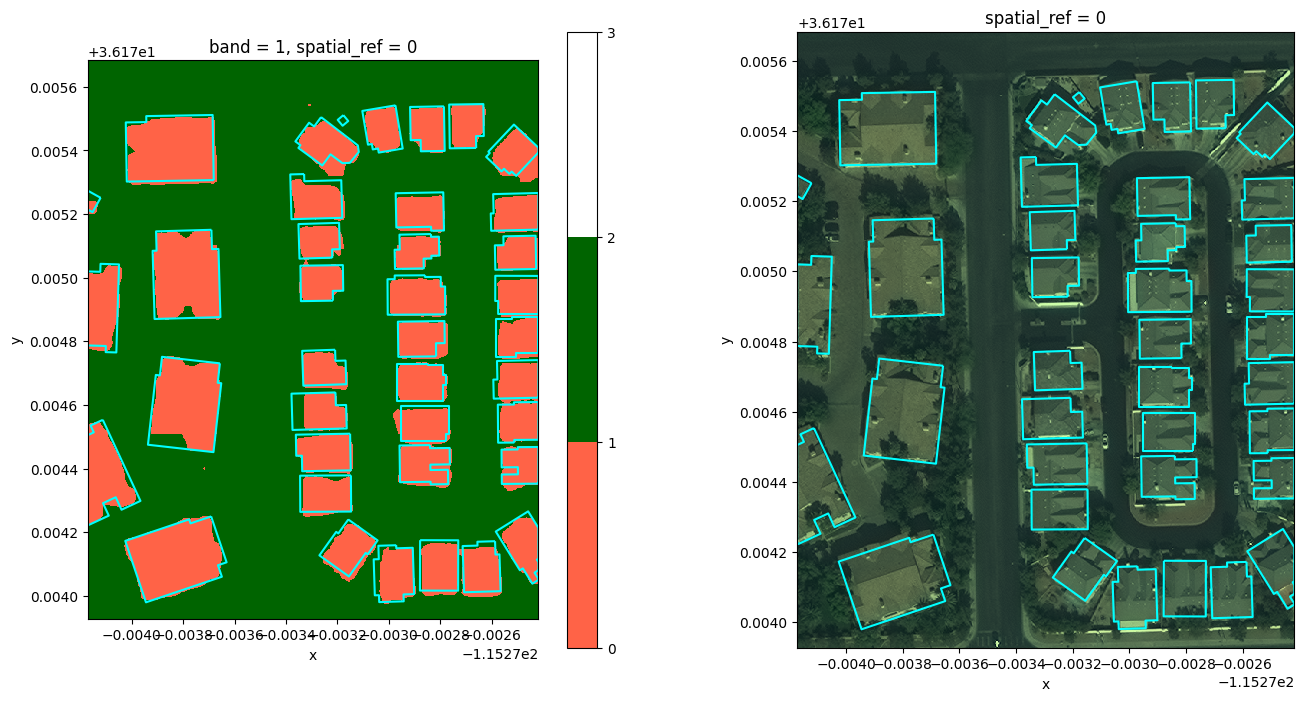

In [37]:
# Visualize predictions with lr=1e-3
plot_prediction(output_1e_minus_3, val_index)

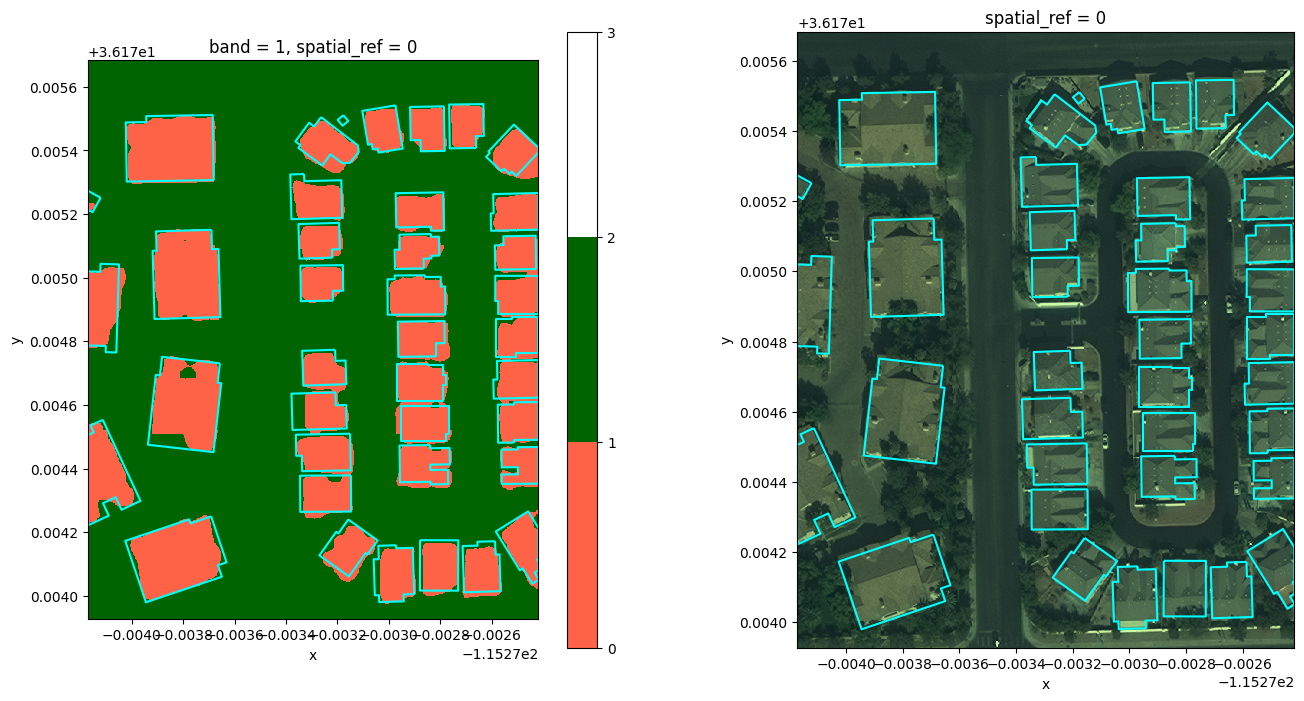

In [16]:
# Visualize predictions with lr=1e-4
plot_prediction(output_1e_minus_4, val_index)

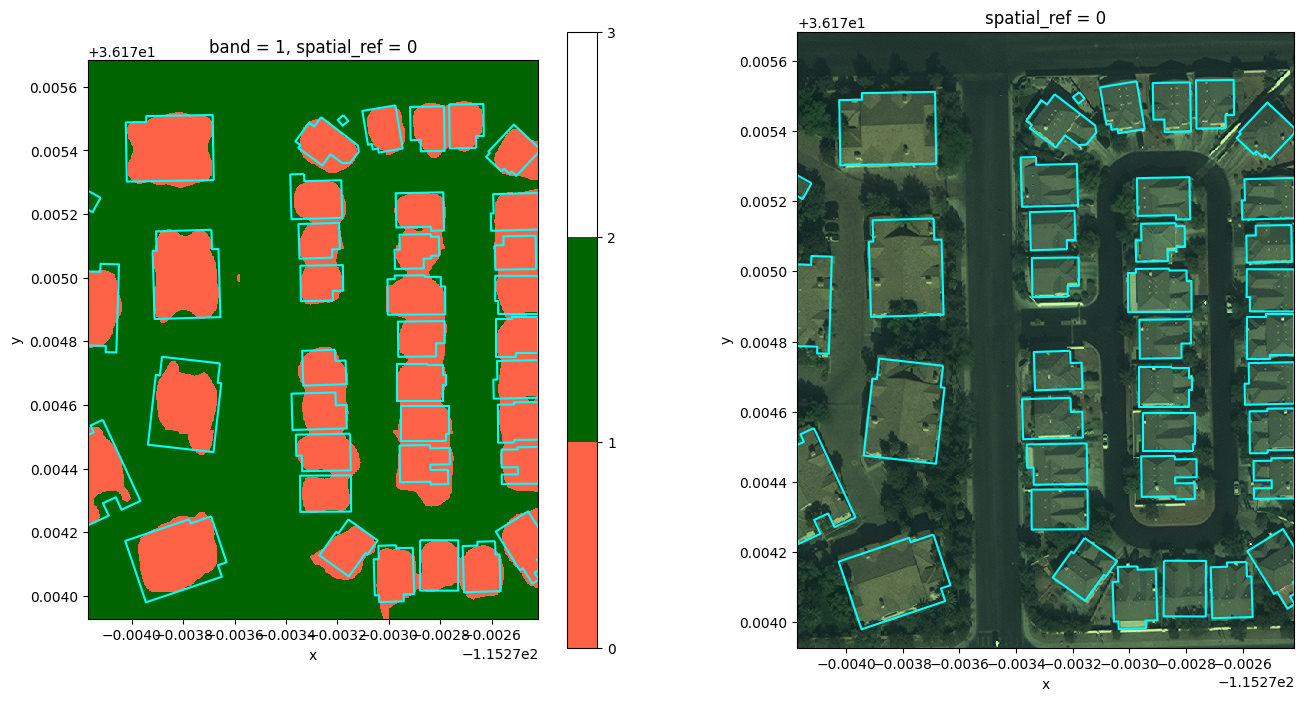

In [17]:
# Visualize predictions with lr=1e-5
plot_prediction(output_1e_minus_5, val_index)

Hooray! We can see here that our predictions cover the entire raster. We can see that the models with learning rates 1e-3 and 1e-4 have different predictions, but it's hard to see if one is better than the other. The model with learning rate 1e-5 shows much fewer pixels predicted as "building" compared to the previous two models. It seems like this learning rate is too slow, and the model wasn't able to learn much over 8 epochs compared to the previous two models with higher learning rates.

#### 4.3.2 Plotting Confusion Matricies

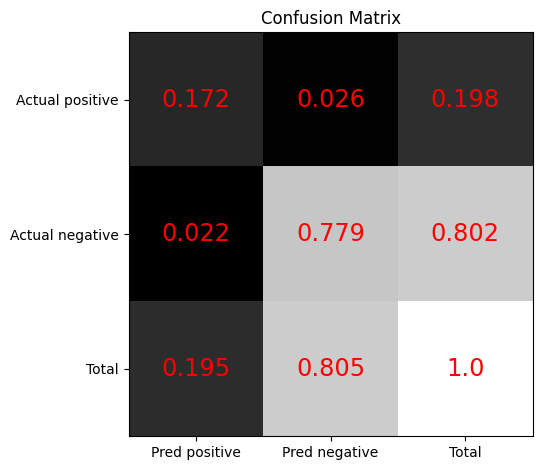

In [18]:
# Plot confusion matrix from model with learning rate 1e-3
display_conf_mat(output_1e_minus_3)

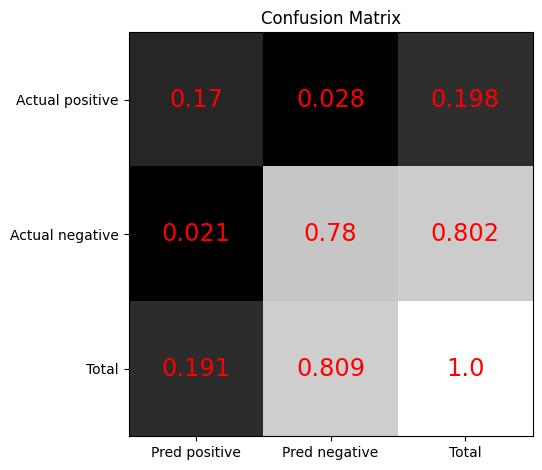

In [19]:
# Plot confusion matrix from model with learning rate 1e-4
display_conf_mat(output_1e_minus_4)

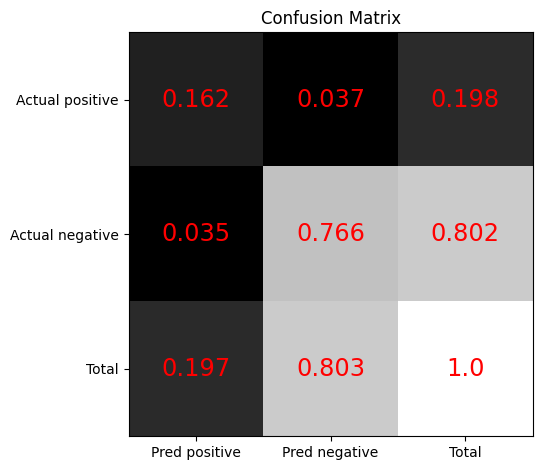

In [20]:
# Plot confusion matrix from model with learning rate 1e-5
display_conf_mat(output_1e_minus_5)

NOA CONTINUE HERE

First, let's analyse the affects of the updates we performed in script 2a. These confusion matricies show us that compared to model 1, model 2a predicts more pixels as "building". We can compare the total proportion of "building" pixel predictions - model 1 predicts 15.8% of all pixels as "building", whereas model 2a predicts 19.5% of all pixels as "building". We see with model 2a a significant decrease in the false negative rate, and an increase in the false positive rate. We also see an proportionally significant increase in the true positive rate, and a proportionally less significant decrease in the true negative rate. Overall, we can assess that these updates represent a slight improvement to model performance.

Next, let's analyse the affects of the updates we performed in script 2b. We see similar changes to performance in model 2b compared to 2a. Like model 2a, model 2b showed an increase in the total proportion of pixels predicted as "building", an increase to the false positive rate, a decrease of the false negative rate, an increase of the true positive rate, and a decrease of the true negative rate. Both models have taken a solid step in the direction of predicting pixels as "building", however model 2a has taken a more significant step in that direction than model 2b. Model 2b shows less of an increase in the false positive rate than model 2a, and model 2b shows less of a decrease in the true negative rate than model 2a.

Before we get too bogged down in the details of this model evaluation, let's remind ourselves that the goal of these updates was just to ensure that our model creates prediction rasters that cover the entire prediction space without ruining our model. We can confirm that this is indeed the case.

#### 4.3.3 Plotting Training Metrics

Finally, let's observe the metrics that Raster Vision collects throughout the training process.

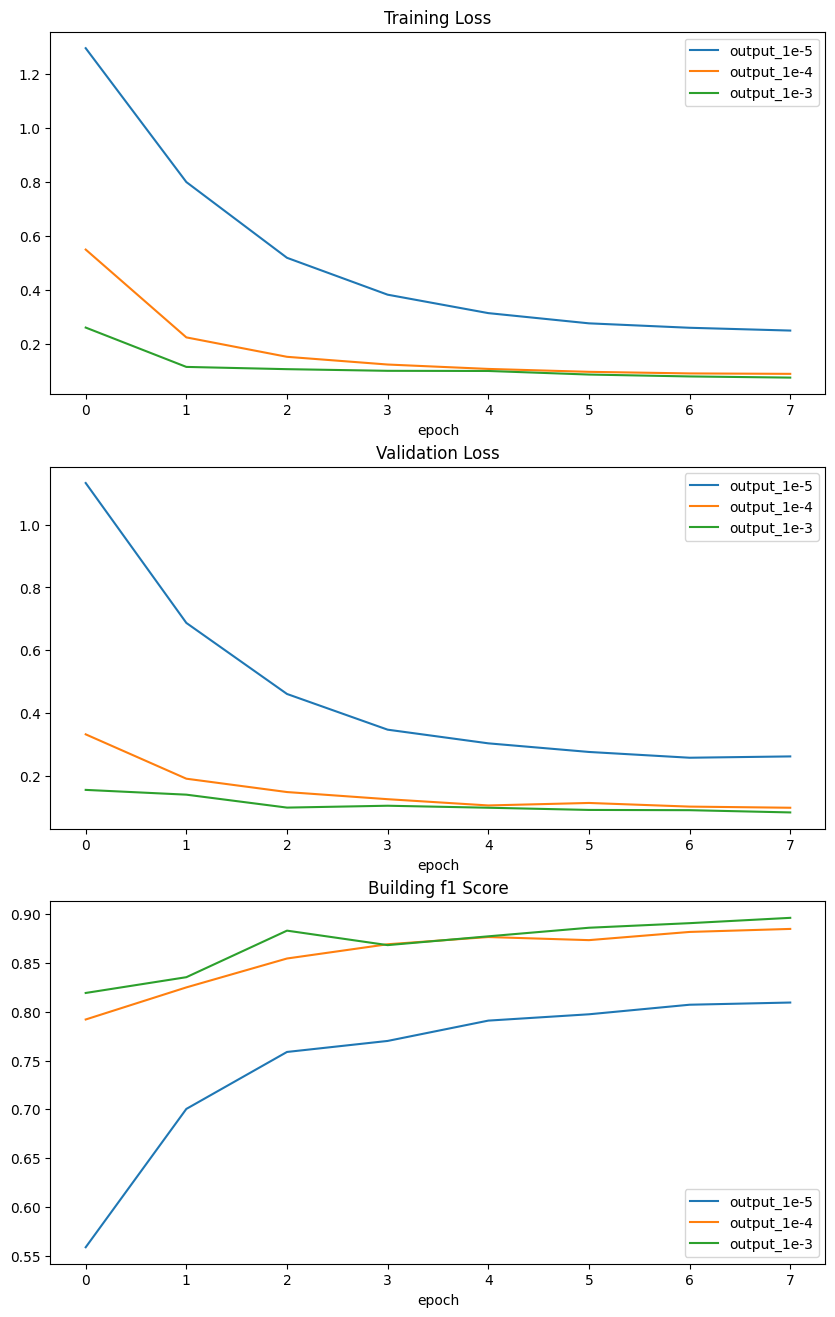

In [18]:
plot_metrics([output_1e_minus_5, output_1e_minus_4, output_1e_minus_3])

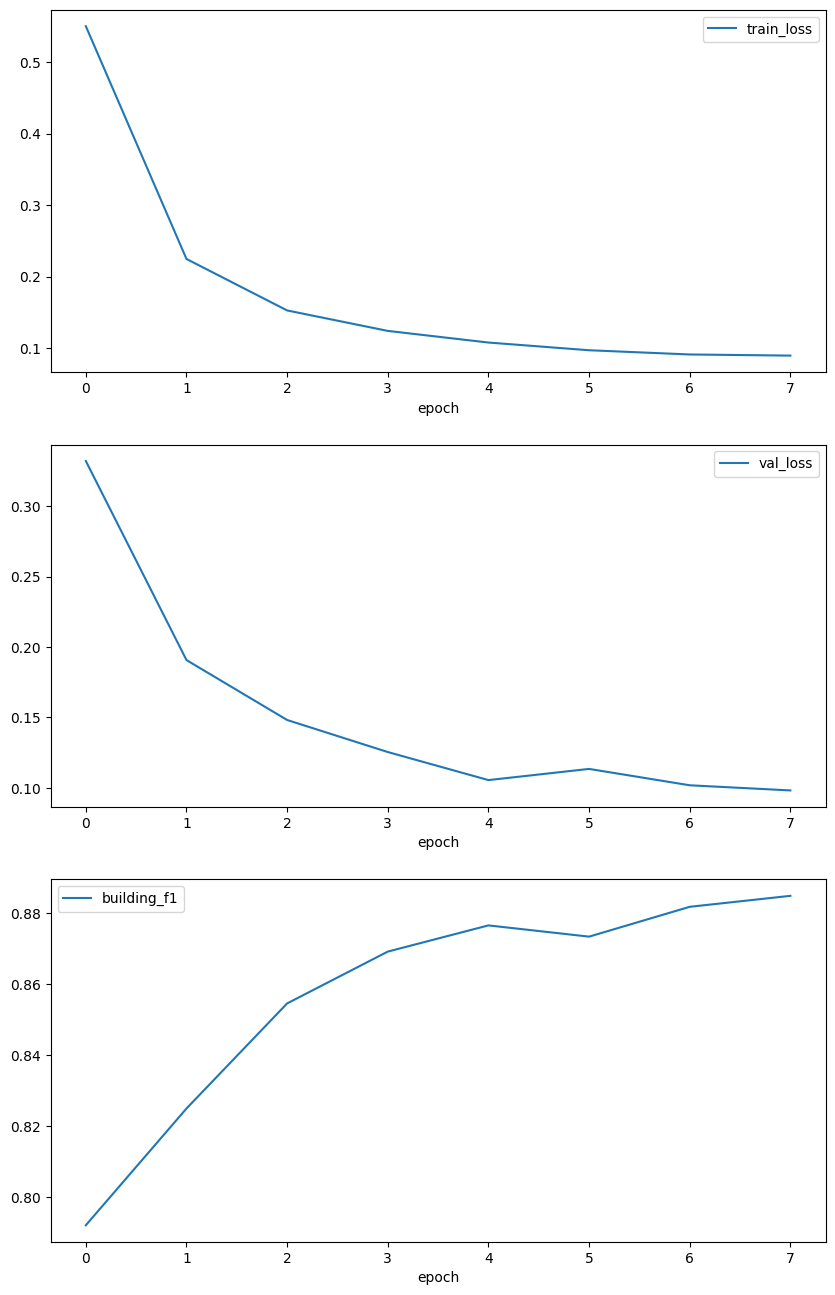

In [22]:
plot_metrics(output_1e_minus_4)

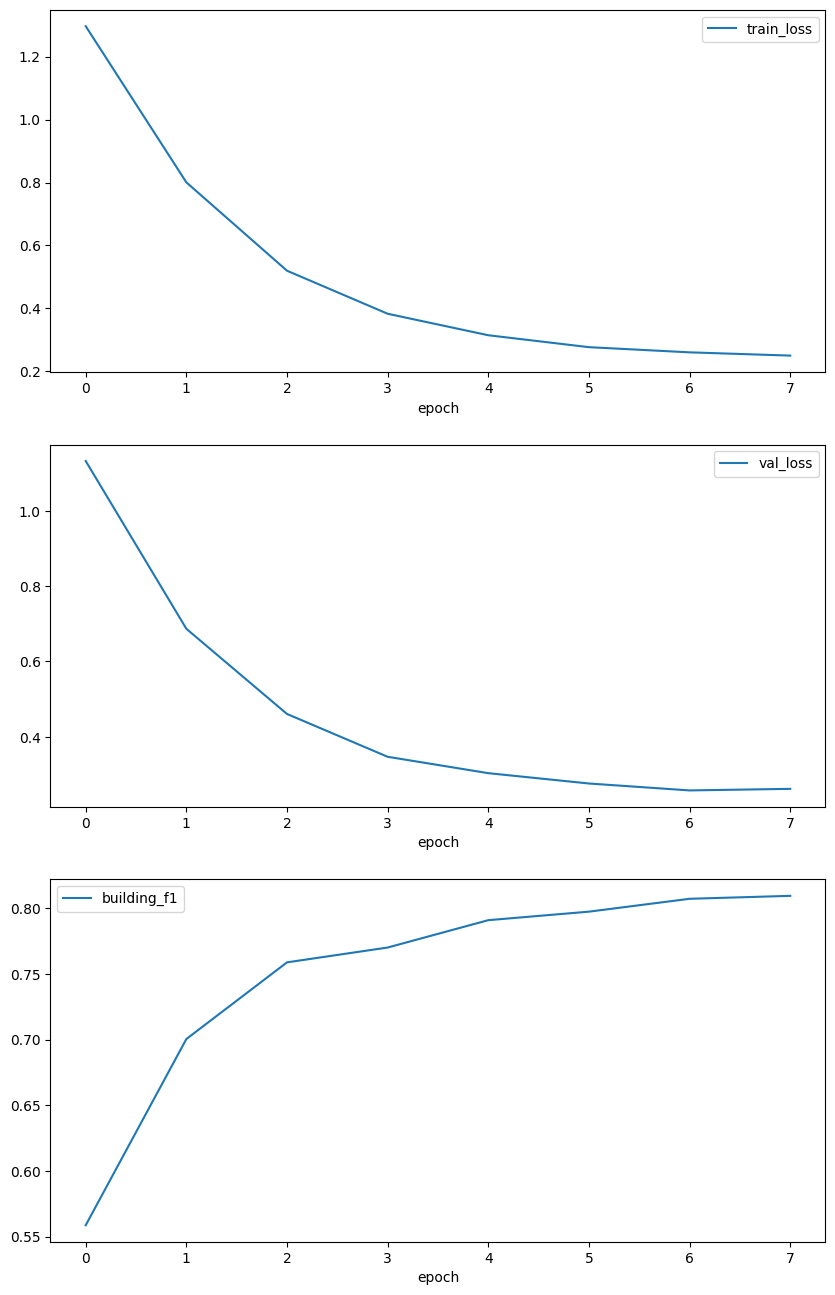

In [23]:
plot_metrics(output_1e_minus_5)

We can see here that all though each model takes different paths, they generally tend to end up in the same place.

#### Conclusion
Not only were we able to update our model to cover the entire prediction space, we were also able to update our hyperparameters to significantly improve model performance. In the next and final tutorial, we will look at how to increase our training data size using data augmentation.